In [41]:
%load_ext autoreload
%autoreload 2

from fisim.assets import Asset, PretaxAsset, TaxableAsset, PretaxPortfolio, TaxablePortfolio
from fisim.events import Action, Event
from fisim.flows import Expense, TaxableIncome
from fisim.model import FinancialModel
from fisim.growth import GrowthType


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
salary = TaxableIncome(name="Salary", initial_value=310_000, state="MA")
housing = Expense(name="Housing", initial_value=40_000, inflation_rate=0.02)
cost_of_living = Expense(name="Cost of Living", initial_value=50_000, inflation_rate=0.03)
health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
mortgage = Expense(name="Mortgage", initial_value=0, inflation_rate=0.0)
cash = Asset(name="Cash", initial_value=50_000, growth_rate=0.01, cap_value=50_000)

In [61]:
# Not used, only included as examples
bonds = TaxableAsset(
    name="Bonds", 
    initial_value=50_000,
    allocation=0.1,
    growth_type=GrowthType.BONDS,
    seed=42
)
stocks = TaxableAsset(
    name="Stocks",
    initial_value=380_000,
    allocation=0.9,
    growth_type=GrowthType.STOCKS,
    seed=42
)

In [62]:
taxable_portfolio = TaxablePortfolio(
    name="Taxable Portfolio",
    initial_value=380_000,
    age=30,
    seed=42,
    number_of_simulations=1_000,
)

In [63]:
_401k = PretaxPortfolio(
    name="401k",
    initial_value=250_000,
    age=30,
    state="MA",
    seed=42,
    number_of_simulations=1_000,
)

In [64]:
# Salary goes to 0
# Health insurance increases by 3000/person per year (2200/year in tax penalties for not having insurance, 400/yr in annual physical and tests, 600 buffer)
quit_job = Event(
    name="Quit Job",
    year=2040,
    actions=[
        Action(
            target=salary,
            action="update_base_values",
            params={"new_base_values": 0, "duration": 100},
        ),
        Action(
            target=health_insurance,
            action="update_base_values",
            params={"new_base_values": 6_000, "duration": 100},
        ),
    ],
)

In [65]:
# Event: buy house
# Investment goes down by down payment (incl fees)
# Note: the 200k for house down payment needs to be invested otherwise it’ll always look like buying a house is better bc oppty cost of investing the down payment is not reflected
# Housing cost goes to 10k/year (house insurance, maintenance) + annual mortgage

house_price = 600_000
downpayment = max(0.2 * house_price, 200_000)
loaned_amount = house_price - downpayment

def get_monthly_mortgage(loaned_amount: float, interest_rate: float, years: int) -> float:
    n = years * 12
    r = interest_rate / 12
    return loaned_amount * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

yearly_mortgage = 12 * get_monthly_mortgage(loaned_amount, 0.07, 30)

buy_house = Event(
    name="Buy House",
    year=2026,
    actions=[
        Action(target=stocks, action="withdraw", params={"amount": 200_000}),
        Action(target=housing, action="update_base_values", params={"new_base_values": 10_000, "duration": 100}),
        Action(target=mortgage, action="update_base_values", params={"new_base_values": yearly_mortgage, "duration": 30}),
    ],
)


In [66]:
#Event: stop investing in 401k
#Allocation to 401k goes to 0
#Salary goes up by 401k minus taxes

stop_investing_in_401k = Event(
    name="Stop Investing in 401k",
    year=2025,
    actions=[
        Action(target=_401k, action="update_cap_deposit", params={"cap_deposit": 0}),
    ],
)

In [67]:
kobold_ipos = Event(
    name="Kobold Ipos",
    year=2028,
    actions=[Action(target=salary, action="add_to_base_values", params={"to_add": 900_000})],
)

In [68]:
planner = FinancialModel(
    revenues=[salary],
    expenses=[housing, cost_of_living, health_insurance],
    assets=[cash, taxable_portfolio, _401k],
    events=[quit_job, buy_house, stop_investing_in_401k],
    duration=30,
    number_of_simulations=10_000,
    # enable_logging=True,
)
planner.run()

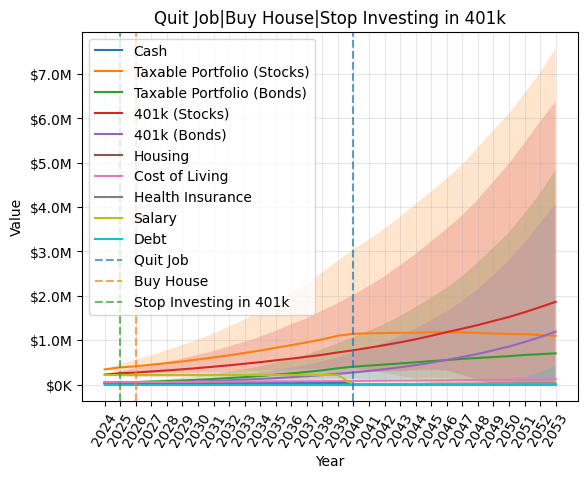

In [69]:
ax = planner.plot_all();
ax.set(title="|".join([e.name for e in planner.events]));

## Parallelize search over several parameters

In [92]:
import itertools
from typing import Iterator, List, Tuple
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from spear.assets import Asset, PretaxAsset, TaxableAsset
from spear.events import Action, Event
from spear.flows import Expense, TaxableIncome
from spear.model import FinancialModel

def instantiate_revenues() -> List[TaxableIncome]:
    salary = TaxableIncome(name="Salary", initial_value=310_000, state="MA")
    return [salary]

def instantiate_expenses() -> List[Expense]:
    housing = Expense(name="Housing", initial_value=40_000, inflation_rate=0.02)
    cost_of_living = Expense(name="Cost of Living", initial_value=50_000, inflation_rate=0.03)
    health_insurance = Expense(name="Health Insurance", initial_value=0, inflation_rate=0.03)
    mortgage = Expense(name="Mortgage", initial_value=0, inflation_rate=0.0)
    return [housing, cost_of_living, health_insurance, mortgage]

def instantiate_assets() -> List[Asset]:
    cash = Asset(name="Cash", initial_value=50_000, growth_rate=0.01, cap_value=50_000)
    bonds = TaxableAsset(name="Bonds", initial_value=50_000, growth_rate=0.03, allocation=0.1)
    stocks = TaxableAsset(
        name="Stocks",
        initial_value=380_000,
        growth_rate=0.08,
        allocation=0.9,
        sample_growth_rates=True,
        seed=42,
    )
    _401k = PretaxAsset(
        name="401k",
        initial_value=250_000,
        growth_rate=0.08,
        cap_deposit=46_000,
        pretax=True,
        sample_growth_rates=True,
        seed=42,
        age=30,
        state="MA",
    )
    return [cash, bonds, stocks, _401k]

def instantiate_events(
        buy_house_year: int,
        quit_job_year: int,
        salary: TaxableIncome,
        health_insurance: Expense,
        mortgage: Expense,
        stocks: TaxableAsset,
        housing: Expense,
) -> List[Event]:
    quit_job = Event(
        name="Quit Job",
        year=quit_job_year,
        actions=[
            Action(
                target=salary,
                action="update_base_values",
                params={"new_base_values": 0, "duration": 100},
            ),
            Action(
                target=health_insurance,
                action="update_base_values",
                params={"new_base_values": 6_000, "duration": 100},
            ),
        ],
    )
    house_price = 600_000
    downpayment = max(0.2 * house_price, 200_000)
    loaned_amount = house_price - downpayment

    def get_monthly_mortgage(loaned_amount: float, interest_rate: float, years: int) -> float:
        n = years * 12
        r = interest_rate / 12
        return loaned_amount * (r * (1 + r) ** n) / ((1 + r) ** n - 1)

    yearly_mortgage = 12 * get_monthly_mortgage(loaned_amount, 0.07, 30)

    buy_house = Event(
        name="Buy House",
        year=buy_house_year,
        actions=[
            Action(target=stocks, action="withdraw", params={"amount": 200_000}),
            Action(target=housing, action="update_base_values", params={"new_base_values": 10_000, "duration": 100}),
            Action(target=mortgage, action="update_base_values", params={"new_base_values": yearly_mortgage, "duration": 30}),
        ],
    )
    return [quit_job, buy_house]


In [93]:
def generate_parameter_combinations(parameters: List[Tuple[int, int]]) -> Iterator[Tuple]:
    """
    Generate all combinations of parameters for ranges generated by start and end.

    Parameters
    ----------
    parameters: List[Tuple[int, int]]
        List of tuples, where each tuple contains the start and end of a range.

    Returns
    -------
    Iterator[Tuple]
        An iterator with all combinations of parameters.
    """
    # Expand each tuple into a range
    expanded_parameters = [range(start, end) for start, end in parameters]
    return itertools.product(*expanded_parameters)

def run_simulation(params: Tuple[int, int]) -> Tuple[int, int, FinancialModel]:
    buy_house_year, quit_job_year = params

    revenues = instantiate_revenues()
    expenses = instantiate_expenses()
    assets = instantiate_assets()
    events = instantiate_events(
        buy_house_year, 
        quit_job_year, 
        revenues[0], 
        expenses[2], 
        expenses[3], 
        assets[2], 
        expenses[0],
    )

    model = FinancialModel(
        revenues=revenues,
        expenses=expenses,
        assets=assets,
        events=events,
        duration=30,
        number_of_simulations=1_000,
    )
    model.run()
    metric = np.sum(model.debt.base_values > 0)
    return buy_house_year, quit_job_year, metric, model


In [94]:
buy_house_years = (2026, 2045)
quit_job_years = (2026, 2045)
#have_kids_years = (2035, 2038)

In [95]:
parameter_combinations = generate_parameter_combinations([buy_house_years, quit_job_years])
results = Parallel(n_jobs=-1)(delayed(run_simulation)(params) for params in parameter_combinations)

In [96]:
columns = ["buy_house_year", "quit_job_year", "metric", "model"]
results_df = pd.DataFrame(results, columns=columns)
results_df.head()

,buy_house_year,quit_job_year,metric,model
0,2026,2026,17998,FinancialModel(revenues=[TaxableIncome(name='S...
1,2026,2027,13789,FinancialModel(revenues=[TaxableIncome(name='S...
2,2026,2028,8957,FinancialModel(revenues=[TaxableIncome(name='S...
3,2026,2029,4145,FinancialModel(revenues=[TaxableIncome(name='S...
4,2026,2030,1169,FinancialModel(revenues=[TaxableIncome(name='S...


<Axes: xlabel='quit_job_year', ylabel='buy_house_year'>

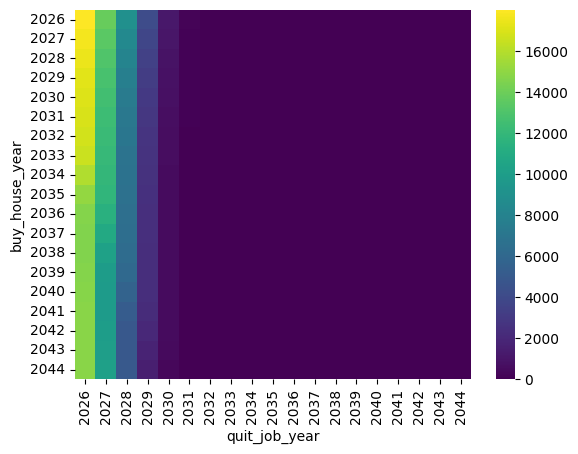

In [110]:
import seaborn as sns

sns.heatmap(results_df.pivot(index="buy_house_year", columns="quit_job_year", values="metric"), cmap="viridis")

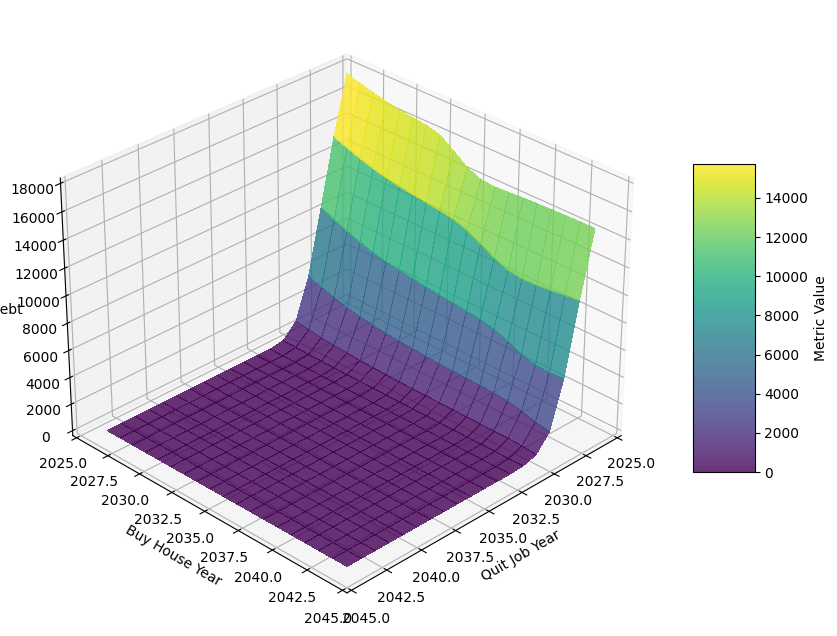

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Create a pivot table
pivot_df = results_df.pivot_table(values='metric', 
                                  index='buy_house_year', 
                                  columns='quit_job_year', 
                                  )

# Create a meshgrid for the x and y axes
X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, pivot_df.values, cmap='viridis', 
                       rstride=1, cstride=1, antialiased=False, alpha=0.8)

# Set labels and title
ax.set_xlabel('Quit Job Year')
ax.set_ylabel('Buy House Year')
ax.set_zlabel('Debt')

# Add a color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Metric Value')

# Improve the angle for better visibility
ax.view_init(elev=30, azim=45)

In [106]:
# Get the row with index 323
row_323 = results_df.iloc[323]

# Display the row
print(row_323)


buy_house_year                                                 2043
quit_job_year                                                  2026
metric                                                        14820
model             FinancialModel(revenues=[TaxableIncome(name='S...
Name: 323, dtype: object


<Axes: xlabel='Year', ylabel='Value'>

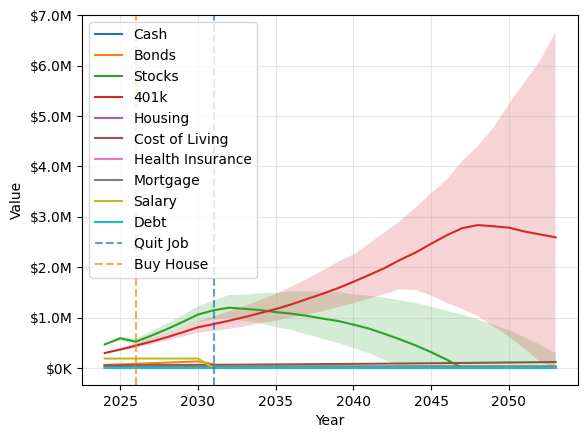

In [116]:
model = results_df.query("quit_job_year == 2031").iloc[0].model
model.plot_all()


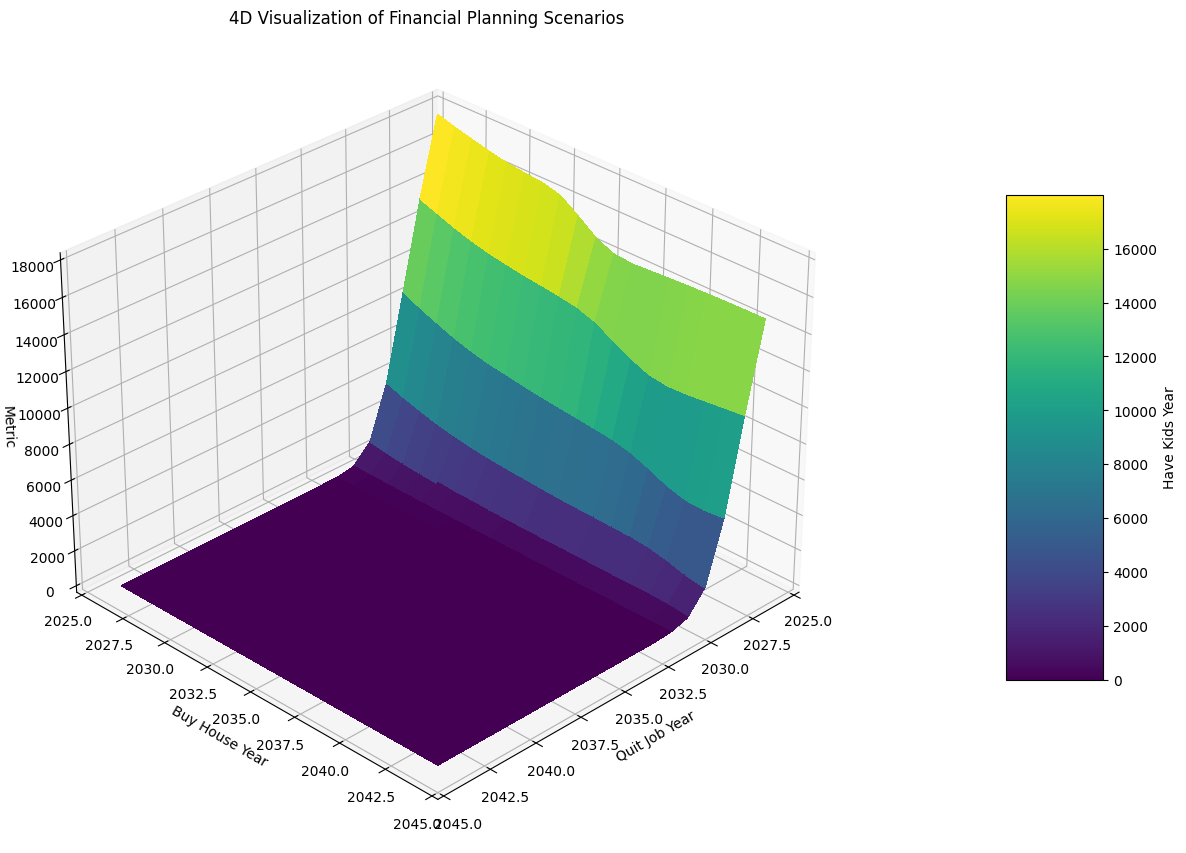

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create pivot tables for metric and have_kids_year
metric_pivot = results_df.pivot(index='buy_house_year', columns='quit_job_year', values='metric')
kids_pivot = results_df.pivot(index='buy_house_year', columns='quit_job_year', values='metric')

# Create a meshgrid for the x and y axes
X, Y = np.meshgrid(metric_pivot.columns, metric_pivot.index)

# Create the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, metric_pivot.values, 
                       facecolors=plt.cm.viridis(kids_pivot.values/kids_pivot.values.max()),
                       rstride=1, cstride=1, antialiased=False, shade=False)

# Set labels and title
ax.set_xlabel('Quit Job Year')
ax.set_ylabel('Buy House Year')
ax.set_zlabel('Metric')
ax.set_title('4D Visualization of Financial Planning Scenarios')

kids_sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=kids_pivot.values.min(), vmax=kids_pivot.values.max()))
kids_sm.set_array([])
cbar_kids = fig.colorbar(kids_sm, ax=ax, shrink=0.5, aspect=5, pad=0.15, label='Have Kids Year')

# Improve the angle for better visibility
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()
